In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import gseapy as gp
import celltypist
from celltypist import models
import scrublet as scr
from scipy.io import mmread

# Inline plotting
%matplotlib inline

/home/mahim/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mahim/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mahim/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

## Read in data and preprocessing

In [2]:
adata = sc.read_10x_mtx(
    './P04/',  
    var_names='gene_symbols',                
    cache=True)

In [3]:
adata.var_names_make_unique() 
adata

AnnData object with n_obs × n_vars = 3844 × 36601
    var: 'gene_ids', 'feature_types'

In [4]:
#adata.raw = adata
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4)
sc.pp.log1p(adata)

In [16]:
adata.obs

,n_counts
AAACCCACAGTCGCAC-1,4987.0
AAACCCAGTCGTATTG-1,111249.0
AAACCCAGTGTCGATT-1,2384.0
AAACGAAGTACGGGAT-1,960.0
AAACGAATCCGCAGTG-1,4205.0
...,...
TTTGTTGGTCGATTCA-1,2114.0
TTTGTTGGTCGTGCCA-1,2111.0
TTTGTTGGTGTAAATG-1,1611.0
TTTGTTGGTTAAGAAC-1,7559.0


## Celltype annotation with celltypist

In [5]:
# Create a CellTypist object and perform cell type annotation
models.download_models(model = ['Immune_All_Low.pkl', 'Immune_All_High.pkl'])

#Select the model from the above list. If the `model` argument is not provided, will default to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_Low.pkl')
#The model summary information.
model
#Examine cell types contained in the model.
model.cell_types
#Examine genes/features contained in the model.
model.features

# Annotate cell types
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl')

# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

📂 Storing models in /home/mahim/.celltypist/data/models
💾 Total models to download: 2
⏩ Skipping [1/2]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/2]: Immune_All_High.pkl (file exists)
🔬 Input data has 3844 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [6]:
adata.obs

,n_counts,predicted_labels,conf_score
AAACCCACAGTCGCAC-1,4987.0,Endothelial cells,0.520176
AAACCCAGTCGTATTG-1,111249.0,Epithelial cells,1.000000
AAACCCAGTGTCGATT-1,2384.0,Late erythroid,0.095757
AAACGAAGTACGGGAT-1,960.0,Tcm/Naive helper T cells,0.497254
AAACGAATCCGCAGTG-1,4205.0,Tem/Trm cytotoxic T cells,0.998193
...,...,...,...
TTTGTTGGTCGATTCA-1,2114.0,Tem/Temra cytotoxic T cells,0.999658
TTTGTTGGTCGTGCCA-1,2111.0,Tem/Trm cytotoxic T cells,0.985357
TTTGTTGGTGTAAATG-1,1611.0,Tcm/Naive helper T cells,0.332638
TTTGTTGGTTAAGAAC-1,7559.0,Tem/Trm cytotoxic T cells,0.221992


In [7]:
# Compute neighborhood graph
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['predicted_labels'], legend_loc = 'right margin')

         Falling back to preprocessing with `sc.pp.pca` and default params.


KeyboardInterrupt: 

## Subset to only CD8 T cells

In [ ]:
# Perform Leiden clustering
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'], legend_loc='on data')  # Plot UMAP with Leiden clustering labels


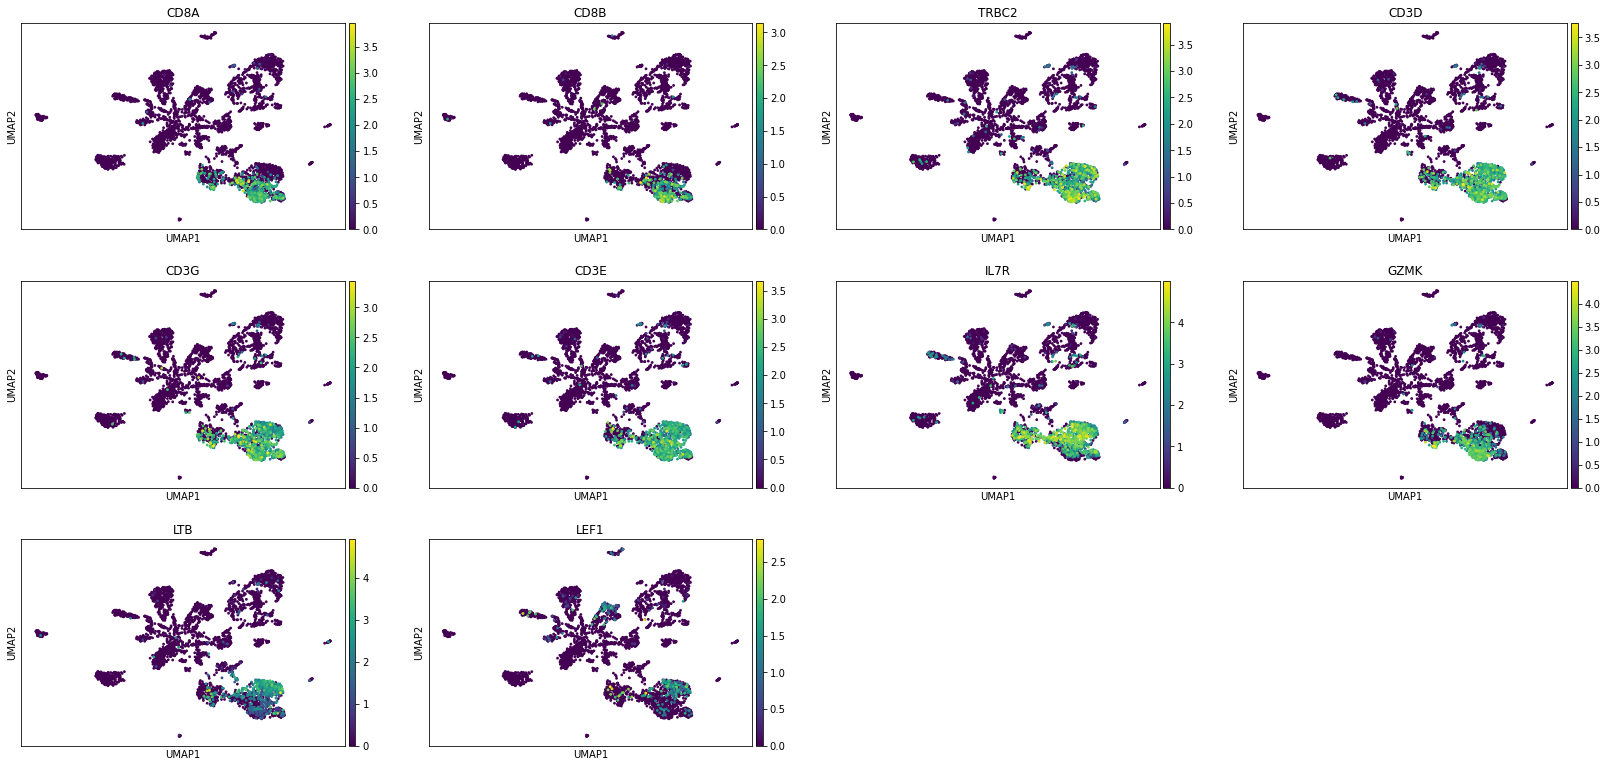

In [28]:
#CD8 cells
sc.pl.umap(adata, color=['CD8A', 'CD8B', 'TRBC2', 'CD3D', 'CD3G', 'CD3E', 'IL7R', 'GZMK', 'LTB', 'LEF1'])

categories: 0, 1, 2, etc.
var_group_labels: CD8+ T Cells, B Cells, NK Cells, etc.


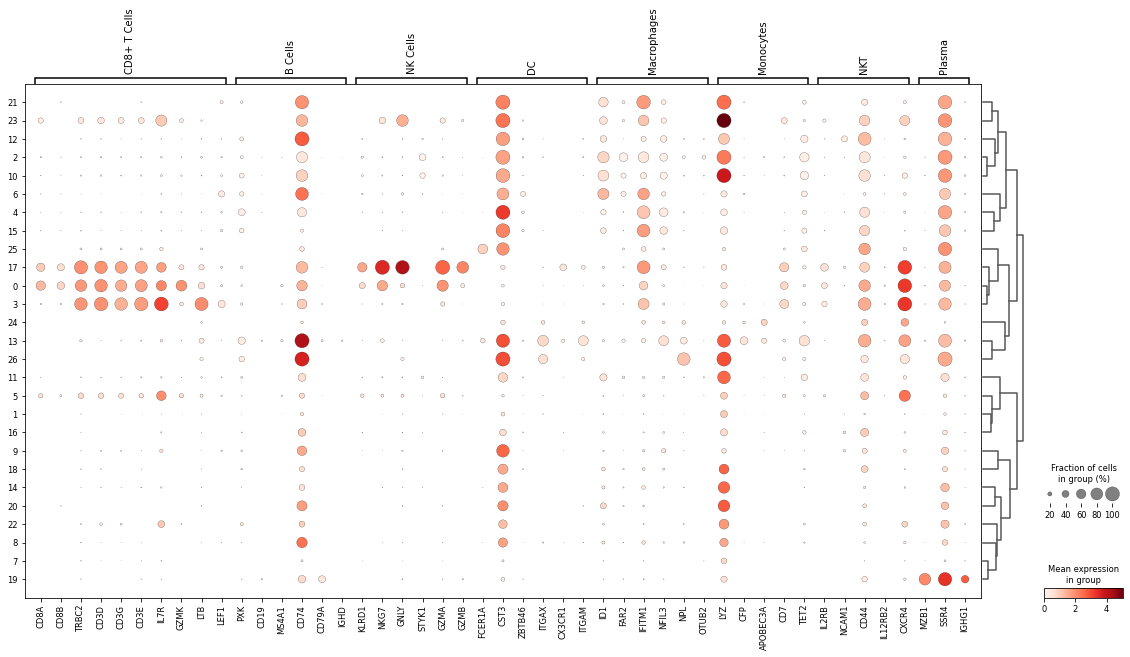

In [29]:
markers = {'CD8+ T Cells' : ['CD8A', 'CD8B', 'TRBC2', 'CD3D', 'CD3G', 'CD3E', 'IL7R', 'GZMK', 'LTB', 'LEF1'], 'B Cells' : ['PXK', 'CD19', 'MS4A1', 'CD74', 'CD79A', 'IGHD'], 'NK Cells' : ['KLRD1', 'NKG7', 'GNLY', 'STYK1', 'GZMA', 'GZMB'], 'DC' : ['FCER1A', 'CST3', 'ZBTB46', 'ITGAX', 'CX3CR1', 'ITGAM'], 'Macrophages' : ['ID1', 'FAR2', 'IFITM1', 'NFIL3', 'NPL', 'OTUB2'], 'Monocytes' : ['LYZ', 'CFP', 'APOBEC3A', 'CD7', 'TET2'], 'NKT' : ['IL2RB', 'NCAM1', 'CD44', 'IL12RB2', 'CXCR4'], 'Plasma' : ['MZB1', 'SSR4', 'IGHG1']}
sc.pl.dotplot(adata, markers, groupby = 'leiden', dendrogram = True, show = False)

plt.savefig('./Pancreas_04_before_filtering_marker_genes_CD8+_T_cells.pdf', dpi = 300, bbox_inches = 'tight')

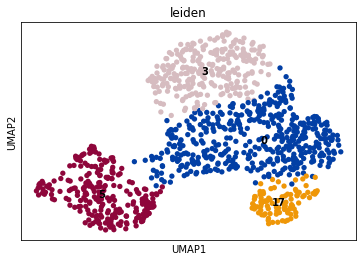

In [30]:
leiden_clusters_to_keep = ['17', '0', '3', '5']
adata_cd8 = adata[adata.obs['leiden'].isin(leiden_clusters_to_keep)]
adata_cd8

# 5. Visualize the results
sc.tl.umap(adata_cd8) 
sc.pl.umap(adata_cd8, color=['leiden'], legend_loc='on data')  

categories: 0, 3, 5, etc.
var_group_labels: CD8+ T Cells, B Cells, NK Cells, etc.


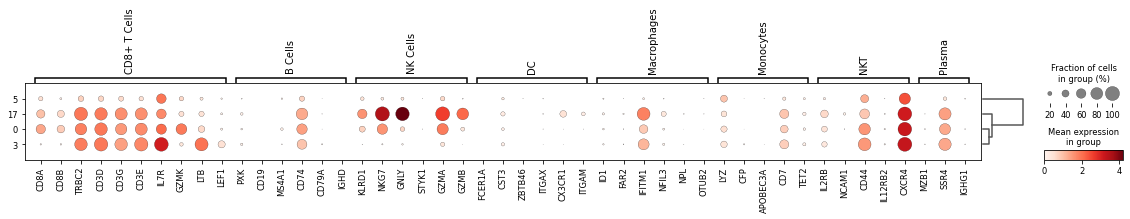

In [20]:
# First, recompute the dendrogram
sc.tl.dendrogram(adata_cd8, groupby='leiden')

# Then, plot the dot plot with the dendrogram
sc.pl.dotplot(adata_cd8, markers, groupby='leiden', dendrogram=True, show=False)

plt.savefig('./Pancreas_04_marker_genes_CD8+_T_cells.pdf', dpi=300, bbox_inches='tight')

## Module score

In [ ]:
single_cell = pd.read_csv('./DEG_high_vs_low_salt_Mahima', sep = '\t')
single_cell.sort_values('avg_log2FC', inplace = True, ascending = False) 
single_cell.head()

In [ ]:
bulk = pd.read_csv('./bulk_CD8_salt.csv')
bulk.sort_values('LFC_cd8_highsalt_vs_cd8_lowsalt', inplace = True, ascending = False) 
bulk.head()

In [ ]:
bulk_upregulated_sig = list(bulk.query('DE_cd8_highsalt_vs_cd8_lowsalt == "upregulated" and (FDR_cd8_highsalt_vs_cd8_lowsalt < 0.001)')['genename'])
bulk_downregulated_sig = list(bulk.query('DE_cd8_highsalt_vs_cd8_lowsalt == "downregulated" and (FDR_cd8_highsalt_vs_cd8_lowsalt < 0.001)')['genename'])

single_cell_upregulated_sig = list(single_cell.query('(avg_log2FC > 0) and (p_val_adj < 0.001)')['Unnamed: 0'])
single_cell_downregulated_sig = list(single_cell.query('(avg_log2FC < 0) and (p_val_adj < 0.001)')['Unnamed: 0'])


gene_set_significant = {'bulk_upregulated'         : bulk_upregulated_sig, 
                       'bulk_downregulated'        : bulk_downregulated_sig,
                       'single_cell_upregulated'   : single_cell_upregulated_sig,
                       'single_cell_downregulated' : single_cell_downregulated_sig
                       }

bulk_salt_group
cd8+_low_salt     802
cd8+_high_salt    258
Name: count, dtype: int64


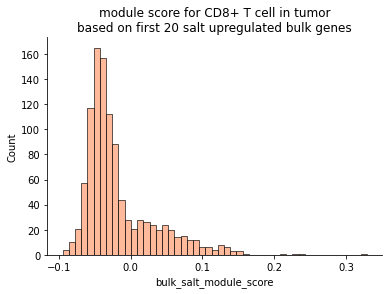

In [47]:
cutof = 60
sc.tl.score_genes(adata_cd8, gene_list=gene_set_significant['bulk_upregulated'][:cutof], score_name='bulk_salt_module_score')

# Set the threshold for low and high salt
threshold = 0

# Create a new column indicating high or low salt based on the threshold
adata_cd8.obs['bulk_salt_group'] = pd.cut(adata_cd8.obs['bulk_salt_module_score'], bins=[-float('inf'), threshold, float('inf')],
                                 labels=['cd8+_low_salt', 'cd8+_high_salt'], include_lowest=True)

print(adata_cd8.obs['bulk_salt_group'].value_counts())
sns.histplot(adata_cd8.obs['bulk_salt_module_score'])
plt.title(f'module score for CD8+ T cell in tumor\nbased on first {cutof} salt upregulated bulk genes')
sns.despine()

plt.savefig(f'./Pancreas_04_module score for CD8+ T cell in tumor\nbased on first {cutof} salt upregulated bulk genes.pdf', dpi=300, bbox_inches='tight')

bulk_salt_group
cd8+_low_salt        711
cd8+_neutral_salt    314
cd8+_high_salt        35
Name: count, dtype: int64


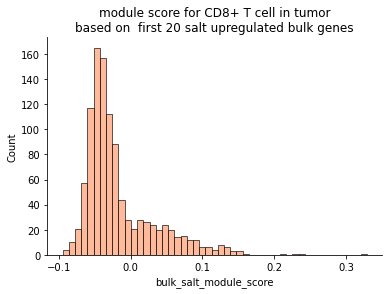

In [45]:
cutof = 20
sc.tl.score_genes(adata_cd8, gene_list=gene_set_significant['bulk_upregulated'][:cutof], score_name='bulk_salt_module_score')

threshold = 0.1

# Create a new column indicating high or low salt based on the threshold
adata_cd8.obs['bulk_salt_group'] = pd.cut(adata_cd8.obs['bulk_salt_module_score'], bins=[-float('inf'), -0.02, threshold, float('inf')],
                                 labels=['cd8+_low_salt', 'cd8+_neutral_salt', 'cd8+_high_salt'], include_lowest=True)

print(adata_cd8.obs['bulk_salt_group'].value_counts())
sns.histplot(adata_cd8.obs['bulk_salt_module_score'])
plt.title(f'module score for CD8+ T cell in tumor\nbased on  first {cutof} salt upregulated bulk genes')
sns.despine()


In [39]:
from importlib import reload
import utilis
utilis = reload(utilis)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


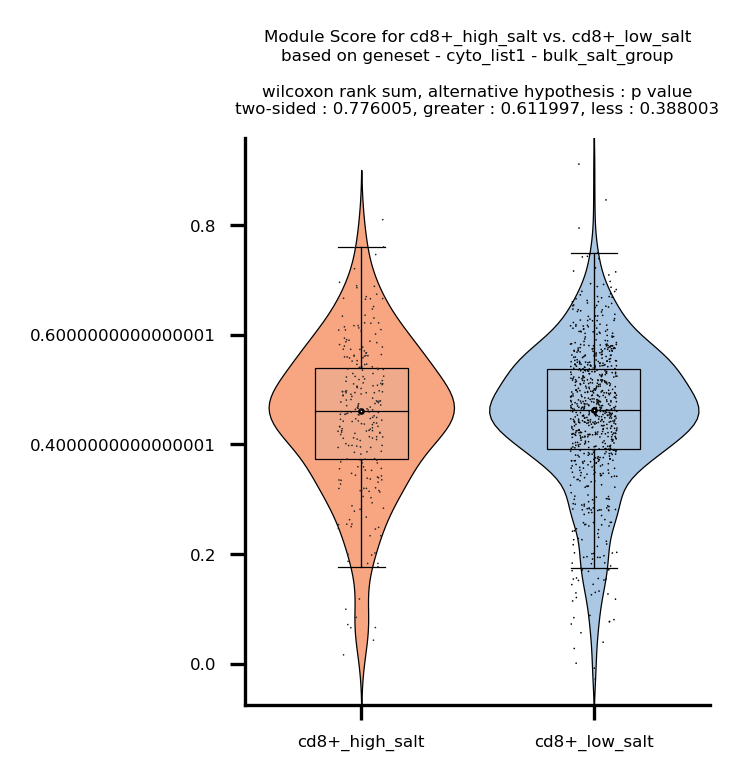

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


--------------------------------------------------------


<Figure size 432x288 with 0 Axes>

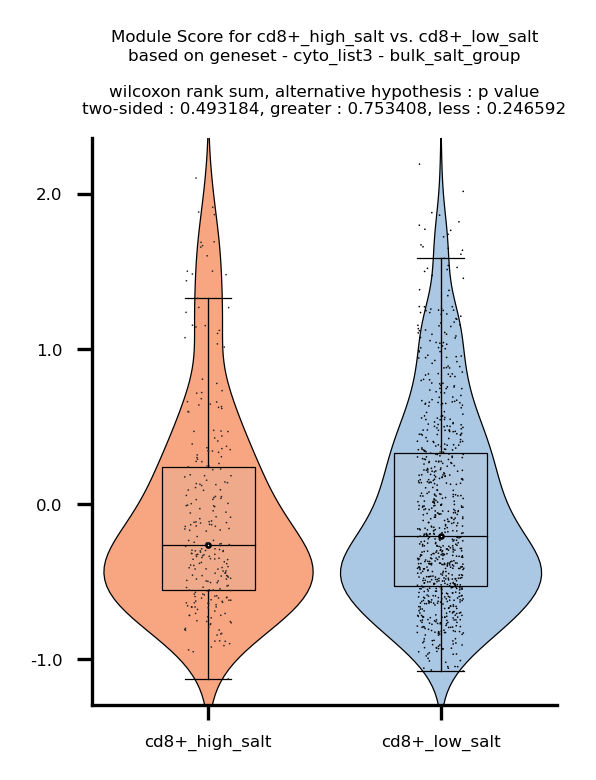

--------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [48]:
genes = {'cyto_list1' : pd.read_csv('./cyto_list1.csv', sep = '\t'),
         'cyto_list3' : pd.read_csv('./cyto_list3.csv', sep = '\t'),
        }

for geneset_name, geneset in genes.items():
    for group in ['bulk_salt_group']:
        utilis.violin_plot(original_adata = adata_cd8,
                colors = ['#ffa37b', '#A7C7E7'],
                group = group, 
                group_conditions = ['cd8+_high_salt', 'cd8+_low_salt'],
                geneset = geneset['genes'],
                geneset_name = f'{geneset_name} - {group}',
                module_score = True)
    print('--------------------------------------------------------')

bulk_salt_group
cd8+_low_salt     861
cd8+_high_salt    199
Name: count, dtype: int64


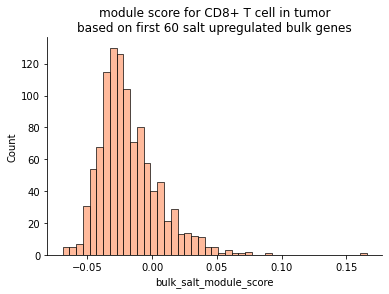

In [42]:
### scRNAseq
cutof = 60
sc.tl.score_genes(adata_cd8, gene_list=gene_set_significant['bulk_upregulated'][:cutof], score_name='bulk_salt_module_score')

# Set the threshold for low and high salt
threshold = 0

# Create a new column indicating high or low salt based on the threshold
adata_cd8.obs['bulk_salt_group'] = pd.cut(adata_cd8.obs['bulk_salt_module_score'], bins=[-float('inf'), threshold, float('inf')],
                                 labels=['cd8+_low_salt', 'cd8+_high_salt'], include_lowest=True)

print(adata_cd8.obs['bulk_salt_group'].value_counts())
sns.histplot(adata_cd8.obs['bulk_salt_module_score'])
plt.title(f'module score for CD8+ T cell in tumor\nbased on first {cutof} salt upregulated bulk genes')
sns.despine()

plt.savefig(f'./Pancreas_04_module score for CD8+ T cell in tumor\nbased on first {cutof} salt upregulated bulk genes.pdf', dpi=300, bbox_inches='tight')